# Labeled faces in the wild.

В данном ноутбуке обучается и исследуются различные metric learning модели на основе датасета Labeled Faces in the Wild (LFW). Нам важно научиться различать лица. Будем это делать, соотнося похожие лица в один и тот же класс. В работе будут сравниваться несколько подходов для выявляения похожих изображений: 

1) Сверточная нейронная сеть (CNN)

2) Метод опорных векторов (SVM)


Исходный датасет есть в sklearn. Импортируем его


In [1]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Сперва загрузим датасет и посмотрим на изображения

In [2]:
lfw_people = fetch_lfw_people( resize=0.5, color=True, min_faces_per_person=10) #подгрузим датасет. 

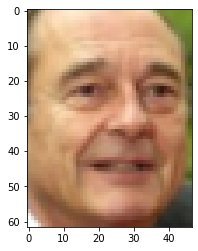

In [ ]:
plt.imshow(lfw_people.images[0]/255)

In [3]:
#посмотрим на число классов
n_classes = lfw_people.target_names.shape[0]
n_classes

158

Исследуем метод, основанный на опорных векторах. 

In [ ]:
X = lfw_people.data
y = lfw_people.target

In [ ]:
#посмотрим на размерность пространства X
X.shape

(4324, 8742)

Видим, что пространство, в котором находится X имеет размерность 8742. Это очень большая размерность, этому нам нужно будет использовать метод снижения размерности. Возьмем PCA с числом главных компонент 200.

In [ ]:
#посмотрим на распределение классов

np.unique(y, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157]),
 array([ 19,  12,  39,  35,  21,  36,  15,  20,  11,  12,  13,  77,  42,
         24,  29,  17,  10,  15

Видно, что в целом есть несбалансированность классов. Попробуем сначала это проигнорировать.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #разделяем данные

In [ ]:
pca = PCA(n_components=200, whiten=True).fit(X_train) #делаем метод снижения размерности
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
"Поставим в SVM несколько экспериментов. Первый эксперимент : Классический SVM с ядром RBF"

model = SVC(kernel='rbf', probability=True)

steps = [('scaler', StandardScaler()), ('clf', model)]
pipeline_svc = Pipeline(steps)

#подберем гиперпараметры 
params = {
    'clf__C': [0.3, 0.7, 1.0, 1.5, 2.0],
}

grid = GridSearchCV(pipeline_svc, params, scoring='roc_auc_ovo_weighted', cv=5, verbose=10)
grid.fit(X_train_pca, y_train)

In [ ]:
#посмотрим теперь на метрику качества
y_proba = grid.best_estimator_.predict_proba(X_test_pca)

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro') #согласно документации в таком случае метрика не чувствительна к дисбалансу классов
print(f'best params: {grid.best_params_}')
print(f'roc auc score = {round(roc_auc,4)}')

best params: {'clf__C': 2.0}
roc auc score = 0.9271


Получилось уже неплохое качество. Теперь можно поставить эксперимент с полиномиальным ядром.

In [ ]:
model = SVC(kernel='poly', probability=True)

steps = [('scaler', StandardScaler()), ('clf', model)]
pipeline_svc = Pipeline(steps)

#подберем гиперпараметры
params = {
    'clf__C': [0.7, 1.0, 1.5, 2.0, 2.5],
    'clf__degree':[3, 4],
    'clf__coef0':[0.0, 1.0, 5.0]
}

grid = GridSearchCV(pipeline_svc, params, scoring='roc_auc_ovo_weighted', cv=5, verbose=10)
grid.fit(X_train_pca, y_train)

In [ ]:
y_proba = grid.best_estimator_.predict_proba(X_test_pca)

roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='macro') #согласно документации в таком случае метрика не чувствительна к дисбалансу классов
print(f'best params: {grid.best_params_}')
print(f'roc auc score = {round(roc_auc,4)}')

best params: {'clf__C': 0.7, 'clf__coef0': 1.0, 'clf__degree': 3}
roc auc score = 0.9321


Получился результат лучше.

# Сверточная нейронная сеть.

Теперь напишем CNN модель. 

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import time
from tqdm.notebook import tqdm
from collections import defaultdict

from IPython.display import clear_output

In [5]:
device = 'cuda'

In [6]:
#Для хранения данных в pytorch создадим Dataset
class PeopleDataset(Dataset):
  """
    PeopleDataset - кастомный датасет для загрузки изображений людей

Атрибуты:
    data: tensor, содержит изображения людей
    target: list, содержит метки классов для изображений

Методы:
    init(self, X, y) - конструктор класса, принимает на вход изображения и метки классов
    len(self) - возвращает длину датасета (число изображений)
    getitem(self, idx) - возвращает idx-ое изображение из датасета и соответствующую ему метку класса
"""


  def __init__(self, X, y):
    self.data = torch.tensor(X)
    self.target = y

  def __len__(self):
    return len(self.target)

  def __getitem__(self, idx):
    
    return self.data[idx].permute(2, 0, 1), self.target[idx] # перестановка местами, для того, чтобы число каналов было сначала.

In [8]:
# создадим функцию train.

def train(model, criterion, optimizer, trainloader, testloader, num_epochs=30):
  """  
  model --     модель
  criterion -- лосс функция
  optimizer -- оптимизатор
  trainloader -- генератор батчей тренировочного датасета
  testloader -- генератор батчет тестового датасета
  num_epochs -- число эпох

  return: 

  model -- обученная модель
  history -- история обучения
   """
  history = defaultdict(lambda: defaultdict(list))

  for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0

    #устанавливаем режим тренировки
    model.train(True)

    for X_batch, y_batch in tqdm(trainloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      logits = model(X_batch)
      loss = criterion(logits, y_batch)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.cpu().detach().numpy()

    train_loss = train_loss/len(trainloader)

    history['loss']['train'].append(train_loss)

    #устанавливаем валидацию
    model.eval()

    with torch.no_grad():
      for X_batch, y_batch in tqdm(testloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = criterion(logits, y_batch)

        test_loss += loss.cpu().detach().numpy()
    
    test_loss = test_loss/len(testloader)

    history['loss']['test'].append(test_loss)

    clear_output()
    print(f'Epoch {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'test_loss = {test_loss}')

  return model, history

In [62]:
#Здесь будет прописана сама модель и её архитектура

class LFW_CNN(nn.Module):

  def __init__(self):
    super(LFW_CNN, self).__init__()

    # первый слой
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.4)
    self.act1 = nn.ReLU()

    #второй слой
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.dropout2 = nn.Dropout(0.4)
    self.act2 = nn.ReLU()

    #третий слой
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.dropout3 = nn.Dropout(0.4)
    self.act3 = nn.ReLU()

    #четвертый слой

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2)
    self.bn4 = nn.BatchNorm2d(num_features=256)
    self.dropout4 = nn.Dropout(0.4)
    self.act4 = nn.ReLU()

    #после трех сверток применим полносвязный слой
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=1536, out_features=1024)
    self.bn5 = nn.BatchNorm1d(num_features=1024)
    self.dropout5 = nn.Dropout(0.4)
    self.act5 = nn.ReLU()

    self.linear2 = nn.Linear(in_features=1024, out_features=512)
    self.bn6 = nn.BatchNorm1d(num_features=512)
    self.dropout6 = nn.Dropout(0.4)
    self.act6 = nn.ReLU()

    self.linear3 = nn.Linear(in_features=512, out_features=256)
    self.bn7 = nn.BatchNorm1d(num_features=256)
    self.dropout7 = nn.Dropout(0.4)
    self.act7 = nn.ReLU()

    self.linear4 = nn.Linear(in_features=256, out_features=256)
    self.bn8 = nn.BatchNorm1d(num_features=256)
    self.dropout8 = nn.Dropout(0.4)
    self.act8 = nn.ReLU()

    self.linear5 = nn.Linear(in_features=256, out_features=n_classes)

  def forward(self, x):
    #применяем сверточные слои
    layer1 = self.act1(self.dropout1(self.bn1(self.pool1(self.conv1(x)))))
    layer2 = self.act2(self.dropout2(self.bn2(self.pool2(self.conv2(layer1)))))
    layer3 = self.act3(self.dropout3(self.bn3(self.pool3(self.conv3(layer2)))))
    layer4 = self.act4(self.dropout4(self.bn4(self.pool4(self.conv4(layer3)))))

    #применяем полносвязные слои
    dense1 = self.flatten(layer4)
    dense1 = self.act5(self.dropout5(self.bn5(self.linear1(dense1))))
    dense2 = self.act6(self.dropout6(self.bn6(self.linear2(dense1))))
    dense2 = self.act7(self.dropout7(self.bn7(self.linear3(dense2))))
    dense2 = self.act8(self.dropout8(self.bn8(self.linear4(dense2))))

    #выход
    out = self.linear5(dense2)
    return out

In [20]:
def get_roc_auc_score(subset, model):
 """
    get_roc_auc_score - функция, вычисляющая метрику ROC AUC для переданного подмножества и модели

Аргументы:

    subset: Dataset, подмножество датасета, на котором нужно вычислить метрику
    model: nn.Module, модель, для которой нужно вычислить метрику

Возвращает:

    test_roc_auc_score: float, значение метрики ROC AUC
"""

  test_roc_auc_score = 0
  testloader = torch.utils.data.DataLoader(subset, batch_size=len(subset), shuffle=False)

  model.eval()
  with torch.no_grad():
    for X_batch, y_batch in tqdm(testloader):
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      logits = model(X_batch)
      softmax = nn.Softmax(dim=1)
      y_proba = softmax(logits.cpu().detach()) #для предсказания вероятности классов нужно сделать softmax

      test_roc_auc_score += roc_auc_score(y_batch.cpu().detach().numpy(), y_proba.numpy(), multi_class='ovo', average='macro')
  
  test_roc_auc_score /= len(testloader)

  return test_roc_auc_score

In [11]:
X = lfw_people.images
y = lfw_people.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(np.unique(y_test))

158

In [12]:
train_set = PeopleDataset(X_train, y_train)
test_set = PeopleDataset(X_test, y_test)

In [13]:
batch_size=32

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
weights = torch.tensor(1/np.unique(y, return_counts=True)[1]).to(device) # веса

In [65]:
model = LFW_CNN().to(device)
criterion = nn.CrossEntropyLoss(weight=weights.float())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

trained_model, history = train(model, criterion, optimizer, trainloader, testloader, num_epochs=500)

Epoch 499
train_loss = 0.3607640582702908
test_loss = 2.410042496288524


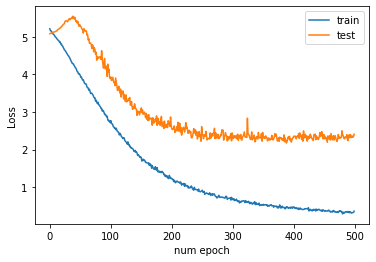

In [66]:
# отображение графиков обучения
plt.plot(history['loss']['train'], label='train')
plt.plot(history['loss']['test'], label='test')
plt.xlabel('num epoch')
plt.ylabel('Loss')
plt.legend()

In [67]:
# отображение метрик на тренировочной и на тестовой выборках
train_roc_auc_score = get_roc_auc_score(train_set, trained_model)
test_roc_auc_score = get_roc_auc_score(test_set, trained_model)
clear_output()
print(f'train roc_auc_score = {round(train_roc_auc_score, 4)}')
print(f'test_roc_auc_score = {round(test_roc_auc_score, 4)}')

train roc_auc_score = 1.0
test_roc_auc_score = 0.979


real label = 82
predict label = 82  probabitity = 0.99962413


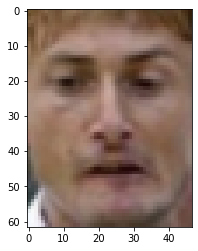

In [70]:
#смотрим на картинку, истинную метку, предсказанную метку и вероятность.
image = train_set.__getitem__(20)
trained_model.eval()
plt.imshow(image[0].permute(1, 2, 0)/255)
image_ = image[0].to(device)
image_.float().shape
image_ = torch.unsqueeze(image_.float(), 0)
image_.shape
logit = model(image_)
softmax = nn.Softmax(dim=1)
probas = softmax(logit.cpu().detach()).numpy()[0]
print(f'real label = {image[1]}')
print('predict label =', np.where(probas == max(probas))[0][0],' probabitity =',max(probas))

# Сверточная сеть. Результаты экспериментов.

Со сверточной нейронной сетью был проделан ряд экспериментов. Я менял гиперпараметры сети, менял архитектуру сети и смотрел, как изменится результат работы от этого. 

Ниже приведена статистика результатов.

**Эксперимент 1.**

Три сверточных слоя, три полносвязных слоя. Архитектура и гиперпараметры:

In [ ]:
  """  # первый слой
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.2)
    self.act1 = nn.ReLU()

    #второй слой
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.dropout2 = nn.Dropout(0.2)
    self.act2 = nn.ReLU()

    #третий слой
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.dropout3 = nn.Dropout(0.2)
    self.act3 = nn.ReLU()

    #после трех сверток применим полносвязный слой
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=4480, out_features=512)
    self.bn4 = nn.BatchNorm1d(num_features=512)
    self.dropout4 = nn.Dropout(0.2)
    self.act4 = nn.ReLU()

    self.linear2 = nn.Linear(in_features=512, out_features=256)
    self.bn5 = nn.BatchNorm1d(num_features=256)
    self.dropout5 = nn.Dropout(0.2)
    self.act5 = nn.ReLU()

    self.linear3 = nn.Linear(in_features=256, out_features=n_classes)
  """

Число эпох 30. 

Результат: 

train roc_auc_score = 1.0

test_roc_auc_score = 0.9792

*** Эксперимент 2. ***

Оставив архитектуру той же самой, увеличим число эпох до 100. Результат:

train roc_auc_score = 1.0

test_roc_auc_score = 0.9802

По графику loss видно, что модель переобучается. 

*** Эксперимент 3 ***

Поменял архитектуру сети. Добавил один полносвязный слой. В результате сеть имеет вид ниже. Число эпох 30. И увеличим dropout


In [ ]:
    """# первый слой
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.3)
    self.act1 = nn.ReLU()

    #второй слой
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.dropout2 = nn.Dropout(0.3)
    self.act2 = nn.ReLU()

    #третий слой
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.dropout3 = nn.Dropout(0.3)
    self.act3 = nn.ReLU()

    #после трех сверток применим полносвязный слой
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=4480, out_features=1024)
    self.bn4 = nn.BatchNorm1d(num_features=1024)
    self.dropout4 = nn.Dropout(0.3)
    self.act4 = nn.ReLU()

    self.linear2 = nn.Linear(in_features=1024, out_features=512)
    self.bn5 = nn.BatchNorm1d(num_features=512)
    self.dropout5 = nn.Dropout(0.3)
    self.act5 = nn.ReLU()

    self.linear3 = nn.Linear(in_features=512, out_features=256)
    self.bn6 = nn.BatchNorm1d(num_features=256)
    self.dropout6 = nn.Dropout(0.3)
    self.act6 = nn.ReLU() """

Результат:

train roc_auc_score = 1.0

test_roc_auc_score = 0.9819


** Эксперимент 4.**

Далее я поменял архитектуру сети. Изменим число сверточных слоёв, добавив еще 1 сверточный слой. Число эпох 50.



In [ ]:
    """# первый слой
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.3)
    self.act1 = nn.ReLU()

    #второй слой
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.dropout2 = nn.Dropout(0.3)
    self.act2 = nn.ReLU()

    #третий слой
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.dropout3 = nn.Dropout(0.3)
    self.act3 = nn.ReLU()

    #четвертый слой

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2)
    self.bn4 = nn.BatchNorm2d(num_features=256)
    self.dropout4 = nn.Dropout(0.3)
    self.act4 = nn.ReLU()

    #после трех сверток применим полносвязный слой
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=1536, out_features=1024)
    self.bn5 = nn.BatchNorm1d(num_features=1024)
    self.dropout5 = nn.Dropout(0.3)
    self.act5 = nn.ReLU()

    self.linear2 = nn.Linear(in_features=1024, out_features=512)
    self.bn6 = nn.BatchNorm1d(num_features=512)
    self.dropout6 = nn.Dropout(0.3)
    self.act6 = nn.ReLU()

    self.linear3 = nn.Linear(in_features=512, out_features=256)
    self.bn7 = nn.BatchNorm1d(num_features=256)
    self.dropout7 = nn.Dropout(0.3)
    self.act7 = nn.ReLU()

    self.linear4 = nn.Linear(in_features=256, out_features=n_classes)
"""

Результат: 

train roc_auc_score = 0.9999

test_roc_auc_score = 0.9753

** Эксперимент 5.**

Изменим архитектуру сети. Добавим еще один полносвязный слой. 

Архитектура ниже. Число эпох 70.

In [ ]:
 """   # первый слой
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.bn1 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.3)
    self.act1 = nn.ReLU()

    #второй слой
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.bn2 = nn.BatchNorm2d(num_features=64)
    self.dropout2 = nn.Dropout(0.3)
    self.act2 = nn.ReLU()

    #третий слой
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.bn3 = nn.BatchNorm2d(num_features=128)
    self.dropout3 = nn.Dropout(0.3)
    self.act3 = nn.ReLU()

    #четвертый слой

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2)
    self.bn4 = nn.BatchNorm2d(num_features=256)
    self.dropout4 = nn.Dropout(0.3)
    self.act4 = nn.ReLU()

    #после трех сверток применим полносвязный слой
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(in_features=1536, out_features=1024)
    self.bn5 = nn.BatchNorm1d(num_features=1024)
    self.dropout5 = nn.Dropout(0.3)
    self.act5 = nn.ReLU()

    self.linear2 = nn.Linear(in_features=1024, out_features=512)
    self.bn6 = nn.BatchNorm1d(num_features=512)
    self.dropout6 = nn.Dropout(0.3)
    self.act6 = nn.ReLU()

    self.linear3 = nn.Linear(in_features=512, out_features=256)
    self.bn7 = nn.BatchNorm1d(num_features=256)
    self.dropout7 = nn.Dropout(0.3)
    self.act7 = nn.ReLU()

    self.linear4 = nn.Linear(in_features=256, out_features=256)
    self.bn8 = nn.BatchNorm1d(num_features=256)
    self.dropout8 = nn.Dropout(0.3)
    self.act8 = nn.ReLU()

    self.linear5 = nn.Linear(in_features=256, out_features=n_classes)"""

Результат: 

train roc_auc_score = 1.0

test_roc_auc_score = 0.9806

*** Эксперимент 6. ***

Оставив архитектуру той же, изменим learning rate, сделаем его 0.0001, число эпох увеличим до 200

Результат:

train roc_auc_score = 1.0

test_roc_auc_score = 0.9815


*** Эксперимент 7 ***

Оставив архитектуру той же изменим dropout с 0.3 до 0.4. learning rate = 1e-4, 500 эпох. 

train roc_auc_score = 1.0

test_roc_auc_score = 0.979

# Лучшая модель.

В результате 8-ми экспериментов со сверточной сетью удалось найти конфигурацию и архитектуру сети, дающую наилучшую метрику на тестовой выборке : 0.9819. Неплохой результат.

